In [2]:
# initialized connection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 as pg

In [3]:
# read pwd string from save file
with open('postgrest_pwd.txt', 'r') as f:
    pwd = f.readline()

In [4]:
# read data from table to datatframe with Month form 201801
table = 'mis_cc_kpi_m'
with pg.connect(database='ktc', user='postgres', password=pwd) as con:
    df = pd.read_sql('select * from ' + table + ' where "month"::bigint >= 201801', con = con)

## Oss Credit card by month
### Approved performance

#### Finalized

In [ ]:
df_gr = df.groupby(['month', 'channel', 'channel_sub'])
df_gr['finalized'].sum().unstack(0).applymap("{:,d}".format)

#### Approve-new

In [ ]:
df_gr['appr_new'].sum().unstack(0).applymap("{:,d}".format)

#### % Appr-rate

In [ ]:
(df_gr['appr'].sum()/df_gr['finalized'].sum()).unstack(0).applymap("{:.0%}".format)

#### Credit limit new

In [ ]:
(df_gr['credit_limit_new'].sum()/df_gr['appr_new'].sum()).unstack(0).applymap("{:,.0f}".format)

#### % active60D

In [ ]:
(df_gr['active60'].sum()/df_gr['appr_new'].sum()).unstack(0).applymap("{:.0%}".format)

In [ ]:
df.groupby(['channel_sub', 'month'])['finalized'].sum().unstack(0).plot()

In [ ]:
df_gr[['finalized', 'appr_new']].sum().stack().unstack(0).applymap("{:,d}".format)

In [ ]:
# group by , sum, reset MultiIndex -> DataFrame
i = df_gr[['finalized', 'appr', 'appr_new']].sum().reset_index()
# create per apr from appr_new / finalzied
i['per_apr'] = (i['appr_new']/i['finalized'])
# Set style
i.style.format({'finalized':"{:,.0f}", 'appr':"{:,.0f}", 'appr_new':"{:,.0f}"}).format({'per_apr':"{:,.0%}"})

### Top Reason
#### OSS - top 5 Decline

In [ ]:
# Filter only result == 'R' and channel == 'OSS'
# then group by month, result_description
# then size() 
# then reset MultiIndex to DataFrame
decline = (df[(df.result == 'R') & (df.channel == 'OSS')]
           .groupby(['month','result_description'])['finalized']
           .size().reset_index())

In [ ]:
# create column rn = sort by finalized, decending order
# group by month, create rn (row_number) by cumcount()  +1
# query only rn (row_number) <= 5 (top 5)
# sort Dataframe by 'month and rn'

top_decline = (decline.assign(rn = decline.sort_values(['finalized'], ascending=False)
               .groupby(['month']).cumcount() + 1)
               .query('rn <= 5')
               .sort_values(['month', 'rn']))

In [ ]:
# transform DataFrame to MultiIndex with pivot, sort by values in 201805
top_decline.pivot(index='result_description', columns='month', values='finalized').sort_values('201805', ascending = False)

Another way of creating top decline

In [ ]:
(df.query('result == "R" and channel == "OSS"')
 .groupby(['month', 'result_description'])
 .size().unstack(0).sort_values('201805', ascending = False).head(5))

OSS - % top 5 decline

In [55]:
# Series of top decline by month and reason
decline = (df.query('result == "R" and channel == "OSS"')
 .groupby(['month', 'result_description'])
 .size())

# Series of finalized by month
finalized = (df.groupby('month').size())

# Series of top decline by month and reason / series of finalized by month, matching by month
(decline.div(finalized, level='month')
 .unstack(0)
 .sort_values('201805', ascending = False)
 .applymap("{:,.0%}".format).head(5))

month,201801,201802,201803,201804,201805
result_description,,,,,
D24,14%,13%,13%,12%,12%
D09,6%,6%,6%,6%,6%
D11,8%,7%,5%,5%,5%
D01,3%,3%,4%,3%,3%
D30,3%,3%,3%,3%,3%


Oss - Top 5 cancel & % top 5 cancel

In [18]:
oss_cancel = (df.query('result == "C" and channel == "OSS"')
              .groupby(['month', 'result_description']).size())
oss_finaize = (df.query('channel == "OSS"').groupby('month').size())

oss_cancel.unstack(0).sort_values('201805', ascending = False).head(5).applymap("{:,.0f}".format)

month,201801,201802,201803,201804,201805
result_description,,,,,
C02,716,838,485,349,595
C04,413,550,495,423,534
C74,162,183,220,251,413
C01,233,217,257,275,367
C03,111,121,156,248,198


In [24]:
(oss_cancel.div(oss_finaize, level = 'month').unstack(0).sort_values('201805', ascending = False)
 .head(5).applymap("{:,.0%}".format))

month,201801,201802,201803,201804,201805
result_description,,,,,
C02,4%,4%,2%,2%,3%
C04,2%,2%,2%,2%,2%
C74,1%,1%,1%,1%,2%
C01,1%,1%,1%,2%,2%
C03,1%,1%,1%,1%,1%


### Demographic group

In [8]:
%matplotlib notebook

<IPython.core.display.Javascript object>


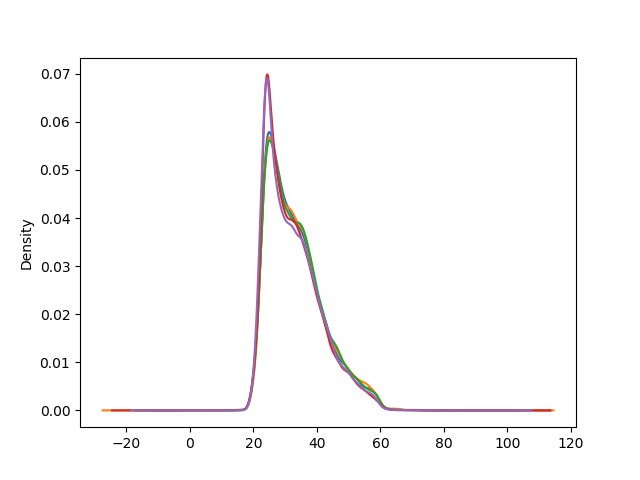

month
201801    AxesSubplot(0.125,0.11;0.775x0.77)
201802    AxesSubplot(0.125,0.11;0.775x0.77)
201803    AxesSubplot(0.125,0.11;0.775x0.77)
201804    AxesSubplot(0.125,0.11;0.775x0.77)
201805    AxesSubplot(0.125,0.11;0.775x0.77)
Name: age, dtype: object

In [14]:
df.loc[df.age > 0].groupby('month')['age'].plot.density()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131434 entries, 0 to 131433
Data columns (total 65 columns):
1sm                       127464 non-null object
1sm_name                  127464 non-null object
1m                        125799 non-null object
1m_name                   125799 non-null object
dm                        39936 non-null object
dm_name                   39936 non-null object
sm                        131434 non-null object
sm_name                   131434 non-null object
m                         131434 non-null object
m_name                    131434 non-null object
amsup                     131434 non-null object
amsup_name                131434 non-null object
tl_code                   131434 non-null object
source_code               131434 non-null object
agent_code                131434 non-null object
zipcode                   131434 non-null object
approve_amount            54936 non-null float64
monthly_salary            131434 non-null float64
no_trans

In [24]:
# use group by
df.groupby(['channel','bkk_upc']).size().unstack(0)

channel,OSS,Tele
bkk_upc,,
BKK,51116,14099
UPC,55015,11155


In [19]:
# use cross tab
pd.crosstab(df.bkk_upc, df.channel)

channel,OSS,Tele
bkk_upc,,
BKK,51116,14099
UPC,55015,11155


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1309b5390>,
      dtype=object)

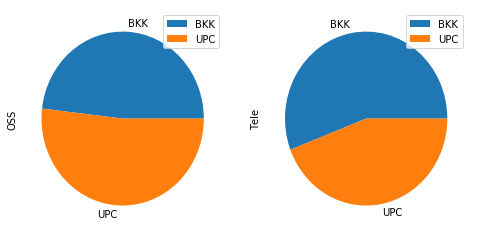

In [36]:
%matplotlib inline
df.groupby(['channel','bkk_upc']).size().unstack(0).plot.pie(subplots = True, figsize=(8,4))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x131a5a828>,
      dtype=object)

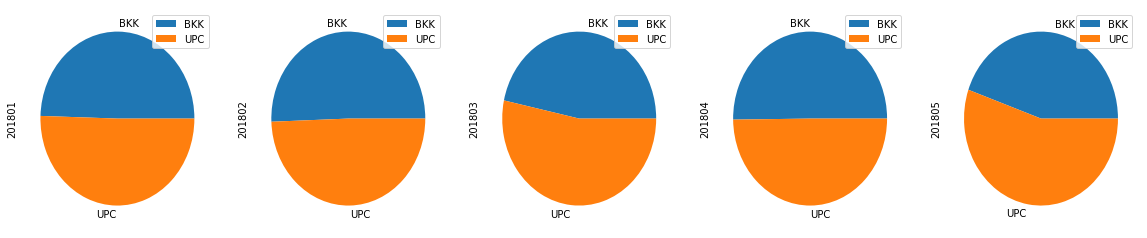

In [45]:
df.groupby(['channel','month','bkk_upc']).size().unstack([0,1])['OSS'].plot.pie(subplots = True, figsize=(20,4))

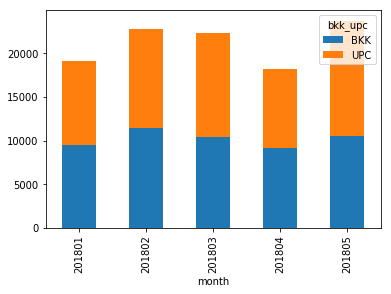

In [63]:
df.groupby(['channel','month','bkk_upc']).size().unstack([0,2])['OSS'].plot.bar(stacked = True)